# Data Visualisation and Features Engineering for Stock Data

In [4]:
import ta
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import seaborn as sns

The code downloads historical price data for a specified stock symbol from Yahoo Finance, adjusts the data, and then resamples it to a weekly frequency. It also calculates the logarithmic returns of the weekly closing prices.

In [15]:
# Define the ticker symbol and timeframe
ticker = "AAPL"
start_date = "2017-01-01"
end_date = "2023-06-09"

# Download the historical data from Yahoo Finance and data adjustment
data = yf.download(ticker, start=start_date, end=end_date)
data['Close']= data['Adj Close']
data = data.drop(['Adj Close'],axis=1)
# Resample the data to weekly frequency
weekly_data = data.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
weekly_data['LogRet'] = np.log(weekly_data.Close/weekly_data.Close.shift())

[*********************100%***********************]  1 of 1 completed


The code creates new features based on technical indicators using the weekly price data. These indicators include Moving Average Volume (MAVol), Relative Strength Index (RSI), Stochastic Oscillator (Stoch), Moving Average Convergence Divergence (MACD), Commodity Channel Index (CCI), Average True Range (ATR), On-Balance Volume (OBV), Money Flow Index (MFI), and Parabolic SAR (PSAR).

After creating the new features, the code performs data cleaning by removing unnecessary columns and dropping any rows with missing values. The length of the original and cleaned data is compared. Finally, the code prepares the target variable (y) by binning the logarithmic returns (LogRet) into three categories using quantiles, and the remaining features (X) are stored for further analysis.

In [16]:
# Creating of new features
weekly_data['mavol'] = weekly_data.Volume.rolling(22).mean()
weekly_data['rsi'] = ta.momentum.RSIIndicator(close=weekly_data['Close']).rsi()
weekly_data['stoch'] = ta.momentum.StochasticOscillator(high=weekly_data['High'], low=weekly_data['Low'], close=weekly_data['Close']).stoch()
weekly_data['macd'] = ta.trend.MACD(close=weekly_data['Close']).macd()
weekly_data['cci'] = ta.trend.cci(weekly_data['High'], weekly_data['Low'], weekly_data['Close'])
weekly_data['atr'] = ta.volatility.AverageTrueRange(high=weekly_data['High'], low=weekly_data['Low'], close=weekly_data['Close']).average_true_range()
weekly_data['obv'] = ta.volume.OnBalanceVolumeIndicator(close=weekly_data['Close'], volume=weekly_data['Volume']).on_balance_volume()
weekly_data['mfi'] = ta.volume.MFIIndicator(high=weekly_data['High'], low=weekly_data['Low'], close=weekly_data['Close'], volume=weekly_data['Volume']).money_flow_index()
weekly_data['psar'] = ta.trend.PSARIndicator(high=weekly_data['High'], low=weekly_data['Low'], close=weekly_data['Close']).psar()

# Data cleaning 
weekly_data = weekly_data.drop(['Open','High','Low'],axis=1)
weekly_data_clean = weekly_data.dropna() 
len(weekly_data), len(weekly_data_clean)
y = pd.qcut(weekly_data_clean['LogRet'], q=3,labels=[1,2,3])
X = weekly_data_clean.drop(['LogRet'],axis=1)
X.info()
X.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2017-07-02 to 2023-06-11
Freq: W-SUN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   311 non-null    float64
 1   Volume  311 non-null    int64  
 2   mavol   311 non-null    float64
 3   rsi     311 non-null    float64
 4   stoch   311 non-null    float64
 5   macd    311 non-null    float64
 6   cci     311 non-null    float64
 7   atr     311 non-null    float64
 8   obv     311 non-null    int64  
 9   mfi     311 non-null    float64
 10  psar    311 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 29.2 KB


,Close,Volume,mavol,rsi,stoch,macd,cci,atr,obv,mfi,psar
count,311.000000,3.110000e+02,3.110000e+02,311.000000,311.000000,311.000000,311.000000,311.000000,3.110000e+02,311.000000,311.000000
mean,95.940303,5.408523e+08,5.493558e+08,59.640532,53.434008,2.784794,55.673603,6.098136,2.152452e+10,58.440809,94.488196
std,49.148082,2.267068e+08,1.365029e+08,12.084017,29.289739,3.731147,96.612691,2.814117,8.468398e+09,19.419501,49.244419
min,33.882393,2.001563e+08,2.989017e+08,26.951406,-39.618683,-5.891143,-244.053547,2.740940,5.991298e+09,5.807613,35.500000
25%,46.009327,3.837652e+08,4.415794e+08,51.500077,33.607450,0.900700,-4.305873,3.300259,1.309350e+10,46.073241,45.262549
50%,85.838928,4.864820e+08,5.301373e+08,60.496682,56.802442,1.865178,73.475524,6.049045,2.245884e+10,58.604318,81.805000
75%,144.624107,6.532814e+08,6.377091e+08,67.187509,78.868433,5.264792,127.000209,8.779096,2.918399e+10,70.244626,139.975611
max,180.949997,1.620264e+09,8.731740e+08,90.055860,99.197223,12.902679,290.128092,11.541533,3.404255e+10,100.000000,182.940002


The code creates a figure with three subplots arranged in a vertical layout.

The first subplot (axs[0]) plots the weekly logarithmic returns (LogRet) over time. The y-axis represents the weekly log return percentage.

The second subplot (axs[1]) displays a histogram of the weekly logarithmic returns. The x-axis represents the logarithmic return values, and the y-axis represents the frequency of occurrence.

The third subplot (axs[2]) plots the weekly closing prices (Close) over time. The x-axis represents the dates, and the y-axis represents the weekly close price in dollars.

The code adjusts the spacing between the subplots and displays the plot.

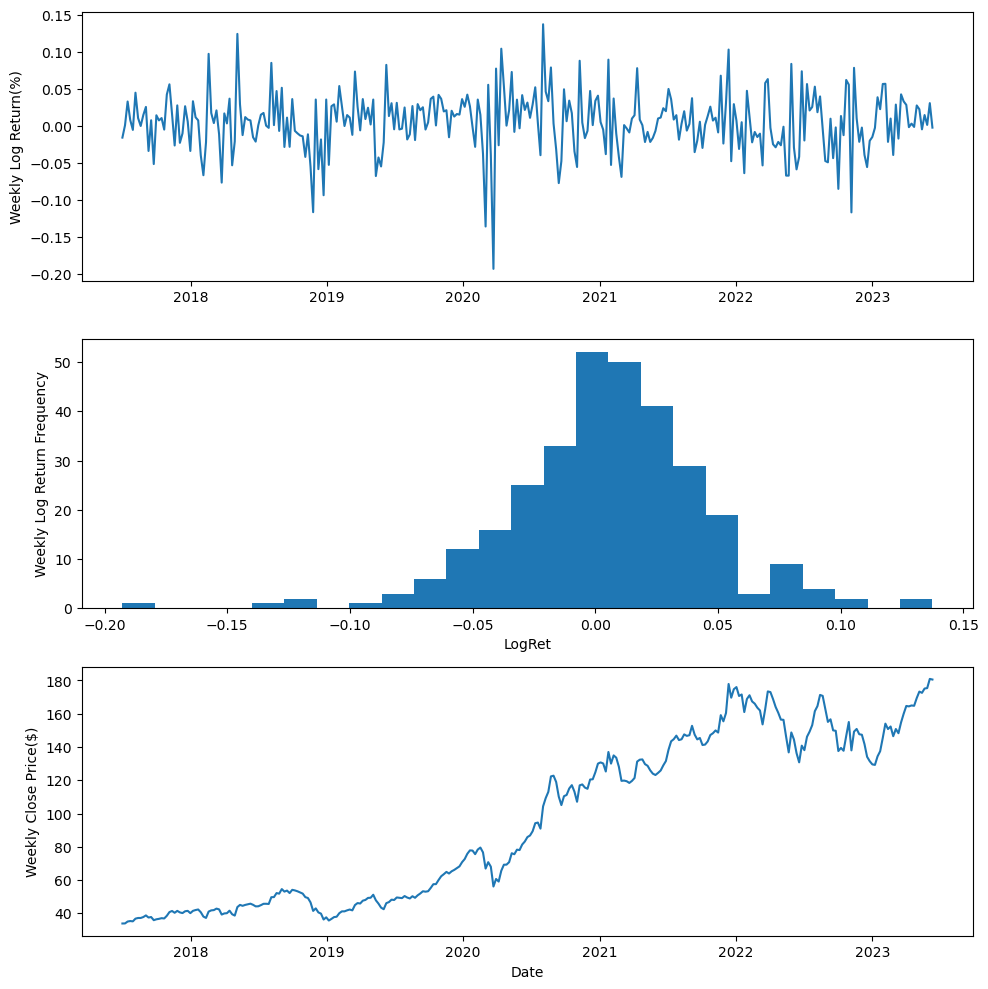

In [24]:
# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot LogRet
axs[0].plot(weekly_data_clean['LogRet'])
axs[0].set_ylabel('Weekly Log Return(%)')

# Plot LogRet histogram
axs[1].hist(weekly_data_clean['LogRet'], bins=25)
axs[1].set_xlabel('LogRet')
axs[1].set_ylabel('Weekly Log Return Frequency')

# Plot Close
axs[2].plot(X['Close'])
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Weekly Close Price($)')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

The code calculates the variance of each feature in the DataFrame X and filters out the features whose variance is below a specified threshold (VarT). It then retrieves the column names of these low-variance features and prints them as a list. This allows you to identify the features that have relatively low variability in their values.

In [31]:
VarT = 12  # Variance threshold value for filtering out
sel = VarianceThreshold(VarT)
sel.fit(X)
VT_feature_names = X.columns[~sel.get_support()].tolist()
print(str(VT_feature_names) + ' is the list of features with variance less than spesified threshold.')

['atr'] is the list of features with variance less than spesified threshold


The code calculates the correlation matrix of the DataFrame X and sets a correlation threshold (correlation_threshold) value. It then identifies the features that have a correlation greater than the threshold or less than its negative counterpart. These highly correlated features are stored in the highly_correlated_features list.

The code then removes duplicate features from the list and prints the final list of features with correlation greater than 0.8 or less than -0.8.

Finally, the code visualizes the correlation matrix as a heatmap using matplotlib and seaborn libraries. The heatmap provides a visual representation of the correlations between different features in the DataFrame.

Features with correlation greater than 0.8 or less than -0.8:
['psar', 'cci', 'Close', 'atr', 'mfi', 'obv', 'rsi']


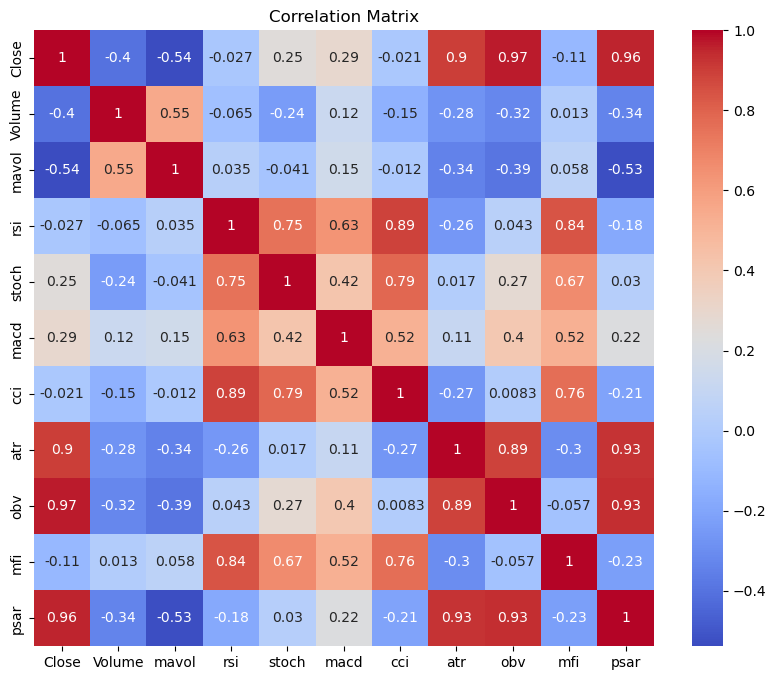

In [32]:
# Feature selection based on correlation
correlation_matrix = X.corr()
correlation_threshold = 0.8

# Find the highly correlated features
highly_correlated_features = []
for feature in correlation_matrix.columns:
    correlated_features = correlation_matrix[abs(correlation_matrix[feature]) > correlation_threshold].index.tolist()
    correlated_features.remove(feature)  # Exclude self-correlation
    if correlated_features:
        highly_correlated_features.extend(correlated_features)

# Remove duplicate features
highly_correlated_features = list(set(highly_correlated_features))

print("Features with correlation greater than 0.8 or less than -0.8:")
print(highly_correlated_features)

plt.figure(figsize=(10, 8))       # Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The provided code performs feature selection using Principal Component Analysis (PCA). It standardizes the features in the dataset and applies PCA to reduce the dimensionality while preserving important information. It calculates the explained variance ratio of each principal component and determines the importance of each feature based on their loadings in the principal components. The features are then sorted based on their importance, and the order of columns in the dataset is updated accordingly. Finally, it prints the new order of features in the dataset.

In [35]:
# Feature selection using PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
pca = PCA(n_components='mle')  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)
print('The ranking of principal components that explain variability of features is as below:')
print(pca.explained_variance_ratio_) # Declear the ranking of principal components
components = pca.components_
feature_importance = np.sum(np.abs(components),axis = 0)
sorted_indexes = np.argsort(feature_importance)[::-1]  # Extract the order of sorted features based PCA
X = X.iloc[:,sorted_indexes]
print('The new order of features based on PCA is as below:')
X.info()

The ranking of principal components that explain variability of features is as below:
[0.39772923 0.34806158 0.12318681 0.04770341 0.03581846 0.02154206
 0.01167028 0.00805892 0.00336671 0.00172422]
The new order of features based on PCA is as below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2017-07-02 to 2023-06-11
Freq: W-SUN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   macd    311 non-null    float64
 1   stoch   311 non-null    float64
 2   cci     311 non-null    float64
 3   atr     311 non-null    float64
 4   mavol   311 non-null    float64
 5   mfi     311 non-null    float64
 6   Volume  311 non-null    int64  
 7   obv     311 non-null    int64  
 8   rsi     311 non-null    float64
 9   psar    311 non-null    float64
 10  Close   311 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 29.2 KB


The provided code demonstrates feature selection using the wrapper method. It involves selecting the most relevant features for two classification models: Support Vector Machine (SVM) and K Nearest Neighbors (KNN).

For the SVM model, the code splits the dataset into training and testing sets, scales the features, and applies the Sequential Feature Selection (SFS) algorithm. The SFS algorithm selects the optimal subset of features based on the specified number of features (k_features) and the scoring metric (accuracy). It then identifies the selected features and prints their names.

The code also includes commented-out code for feature selection with the KNN model. It follows a similar process, where the dataset is split, features are scaled, and the SFS algorithm is applied. However, this part is currently disabled with comment symbols (#) and is not executed.

Overall, the code demonstrates how to perform feature selection using wrapper methods with different classification models.

In [43]:
#Feature Selection using Wrapper Method

# Feature selection for classification Support Vectore Machin model
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.20)
sfs = SFS(SVC(), k_features=5, verbose=2, scoring='accuracy')
sfs.fit(X_train,y_train)
selected_features = X_train.columns[list(sfs.k_feature_idx_)]
print("Selected Features for SVC model:", X.columns[selected_features].tolist())

# Feature selection for classification K Nearest Neighbors model
#X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.20)
#sfs = SFS(KNC(), k_features=5, verbose=2, scoring='accuracy')
#sfs.fit(X_train,y_train)
#selected_features = X_train.columns[list(sfs.k_feature_idx_)]
#print("Selected Features for KNC model:", X.columns[selected_features].tolist())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished

[2023-06-11 22:04:06] Features: 1/5 -- score: 0.4557551020408163[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished

[2023-06-11 22:04:07] Features: 2/5 -- score: 0.5404897959183674[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished

[2023-06-11 22:04:07] Features: 3/5 -- score: 0.5365714285714287[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

Selected Features for SVC model: ['macd', 'stoch', 'cci', 'Volume', 'rsi']


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s finished

[2023-06-11 22:04:07] Features: 5/5 -- score: 0.5519183673469387